<a href="https://colab.research.google.com/github/OlegBEZb/NLP_advanced_course/blob/master/HW2/HW2_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About notebook

Dataset
*	Groningen Meaning Bank (version 2.2.0)
*	Task: named entity recognition
*	Target – named entity tags (BIO + entity type)
*	Input data: 
  * Use “en.met” files to extract the subcorpus
  corpus = 'Voice of America' (for honogeneity of the input data set)
  * Use "en.tags" files for the main input data:
      *	raw tokens + may use the lemmas and the POS-tags 
  (i.e. take the “golden” POS-tagging);
      *	which means:
        *	first three columns for input: ['word', 'pos', 'lemma']
        *	the fourth column for target variable (‘ne_tags’)
        (BIO annotation + the named-entity type in one tag)  

# Tasks

1.	The most trivial model = supervised HMM:
  *	Take hmmlearn (former sklearn), modify MultinomialHMM (I.e. inherit a new class from _BaseHMM making it a modified copy of the latter) to allow for supervised HMM training. The states of the HMM model = the NE tags.
  *	NOTE: may use NaiveBayes to learn emission probabilities in a supervized manner.
  *	Or implement from scratch (with Viterbi for prediction).
  *	NOTE: use tuples of features for X (not just the word, but additional info).
  *	NOTE: use smoothing for state transitions.
2.	CRF
  *	Modify the input features;
  *	Use CRFSuite.
3.	Bi-LSTM:
  *	Use keras or tensorflow;
  *	https://github.com/hse-aml/natural-language-processing/blob/master/week2/week2-NER.ipynb
  *	A plus for incorporating CNN-layers;

# Metrics

* normalized confusion matrices, precision, recall, F-score 
(macro- and micro-) 
* (token level, entity level, partial matching (i.e. boundary-detection problem), binary).  
NOTE: taking into account vocabulary transfer is a plus.

http://www.davidsbatista.net/blog/2018/05/09/Named_Entity_Evaluation/  
http://larsmans.github.io/seqlearn/reference.html#module-seqlearn.datasets

# Evaluation Criteria

Scoring (14.5 max):  
*	Dataset overview – 0.5
  *	text lengths, vocabulary size, frequencies of patterns (<UNK-type-i>) 
  *	stats over the target tags
*	Feature engineering – 2 (1+1)
  *	grammatical words = closed set (~ stop words)
  *	Stemming + POS
  *	Word shape
  *	Ad hoc features ( +1)  
*	Word patterns -> encode types of unknown words +0.5
*	Smoothing in HMM – 0.5 
  *	In HMM: for state transitions.
*	Incorporating tupled features in HMM (on top of tokens) – 1
*	The correct HMM implementation – 1
*	More fine-grained feature engineering for the Neural Network + 0.5
  *	Differentiate between POS-relevancy for the word and the context, etc.
  *	Sentence-level features (may use “golden” sentence-splitting)
*	Evaluation (on all levels) – 1
*	Conclusion on HMM deficiency (as a model) – 1
*	CRF: 1 point for use and evaluation, + 0.5 points for comparison and conclusions;
*	NN:
  *	Main network: 4
  *	CNN layers: +2  

Libraries: hmmlearn, crfsuite, tensorflow, keras

# Libs import

## Downloading, upgrading libs, fixing bugs in seqlearn

In [116]:
!pip install sklearn-crfsuite
!pip install -U scipy
!pip install seqlearn
!pip install seqeval
!pip install hmmlearn==0.2.2
!pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip install eli5

Requirement already up-to-date: scipy in /usr/local/lib/python3.6/dist-packages (1.4.1)
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-0nskd41g
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-0nskd41g
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=918824bf8863df9a2f59594cf92bb6461a1227e17047c450f0508be66380e188
  Stored in directory: /tmp/pip-ephem-wheel-cache-v5lb5zjt/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
     |████████████████████████████████| 112kB 3.4MB/s 


There is unsolved issue https://github.com/larsmans/seqlearn/issues/45  
And there is no opportunity to use lower version of scipy because of other dependencies  
Also there is a [bug](https://github.com/larsmans/seqlearn/pull/29) with calculating final probabilities which is fixed below

In [0]:
!rm /usr/local/lib/python3.6/dist-packages/seqlearn/hmm.py

In [118]:
%%writefile /usr/local/lib/python3.6/dist-packages/seqlearn/hmm.py

"""Hidden Markov models (HMMs) with supervised training."""

import numpy as np
#from scipy.misc import logsumexp
from scipy.special import logsumexp

from .base import BaseSequenceClassifier
from ._utils import atleast2d_or_csr, count_trans, safe_sparse_dot


class MultinomialHMM(BaseSequenceClassifier):
    """First-order hidden Markov model with multinomial event model.

    Parameters
    ----------
    decode : string, optional
        Decoding algorithm, either "bestfirst" or "viterbi" (default).
        Best-first decoding is also called posterior decoding in the HMM
        literature.

    alpha : float
        Lidstone (additive) smoothing parameter.
    """

    def __init__(self, decode="viterbi", alpha=.01):
        self.alpha = alpha
        self.decode = decode

    def fit(self, X, y, lengths):
        """Fit HMM model to data.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            Feature matrix of individual samples.

        y : array-like, shape (n_samples,)
            Target labels.

        lengths : array-like of integers, shape (n_sequences,)
            Lengths of the individual sequences in X, y. The sum of these
            should be n_samples.

        Notes
        -----
        Make sure the training set (X) is one-hot encoded; if more than one
        feature in X is on, the emission probabilities will be multiplied.

        Returns
        -------
        self : MultinomialHMM
        """

        alpha = self.alpha
        if alpha <= 0:
            raise ValueError("alpha should be >0, got {0!r}".format(alpha))

        X = atleast2d_or_csr(X)
        classes, y = np.unique(y, return_inverse=True)
        lengths = np.asarray(lengths)
        Y = y.reshape(-1, 1) == np.arange(len(classes))

        end = np.cumsum(lengths)
        start = end - lengths

        init_prob = np.log(Y[start].sum(axis=0) + alpha)
        init_prob -= logsumexp(init_prob)
        #final_prob = np.log(Y[start].sum(axis=0) + alpha)
        final_prob = np.log(Y[end - 1].sum(axis=0) + alpha)
        final_prob -= logsumexp(final_prob)

        feature_prob = np.log(safe_sparse_dot(Y.T, X) + alpha)
        feature_prob -= logsumexp(feature_prob, axis=0)

        trans_prob = np.log(count_trans(y, len(classes)) + alpha)
        trans_prob -= logsumexp(trans_prob, axis=0)

        self.coef_ = feature_prob
        self.intercept_init_ = init_prob
        self.intercept_final_ = final_prob
        self.intercept_trans_ = trans_prob

        self.classes_ = classes

        return self

Writing /usr/local/lib/python3.6/dist-packages/seqlearn/hmm.py


## Importing libs

In [145]:
%autosave 180
%load_ext autoreload
%autoreload 2

from nltk import word_tokenize, pos_tag, ne_chunk
import sys
from copy import deepcopy
import os
import numpy as np
import pandas as pd
import codecs
from collections import Counter
import re
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import eli5

from itertools import chain
from functools import wraps

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, cross_validate, KFold, ParameterGrid, RandomizedSearchCV    
from sklearn.pipeline import Pipeline
from sklearn_crfsuite import CRF

from seqlearn.hmm import MultinomialHMM as seqlearn_MHMM
from hmmlearn.hmm import MultinomialHMM as hmmlearn_MHMM
from seqlearn.evaluation import SequenceKFold, bio_f_score
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import recall_score, roc_auc_score, make_scorer, f1_score, fbeta_score, classification_report
from seqeval.metrics import classification_report as entity_classification_report

import keras.backend as k
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model, Input, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Masking, GRU, SpatialDropout1D, add, concatenate, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping
from keras_contrib.layers import CRF as CRF_layer

import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)-9s [%(asctime)s] : %(message)s', stream=sys.stdout)

%matplotlib inline

Autosaving every 180 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Configs

In [0]:
COLAB = True
test_size = 0.2
subcorpus = 'Voice of America'

The raw data was preprocessed on my own PC bacause of google drive limitations.

In [125]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    data_folder = '/content/drive/My Drive/Advanced NLP/Homework 2: Named entity recognition on Groningen Meaning Bank dataset'
else:
    data_folder = 'D:\Data\gmb-2.2.0\data'
    print('data found:', os.listdir(data_folder))
    
print('data found:', os.listdir(data_folder))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
data found: ['HW1. NER.ipynb', 'Voice of America.csv', '__pycache__', 'bert.py']


# Data extraction

Parsing data from "Voice of America" subcorpus. According to the instructions we take first four columns and additional column to separate data on texts, sentences or words.

In [0]:
%%time

voa_data = pd.DataFrame(columns=['word', 'pos', 'lemma', 'ne_tags', 'text_id'])

os.chdir(data_path)
part_paths = os.listdir()

for part_path in tqdm(part_paths, total=len(part_paths)):
    os.chdir(part_path)
    document_paths = os.listdir()
    for document_path in document_paths:
        os.chdir(document_path)
        f = codecs.open("en.met", 'r', "utf_8_sig")
        file_met = f.read()
        if ('subcorpus: {}'.format(subcorpus) in file_met):
            tags_df = pd.read_csv('en.tags',
                                  sep='\t',
                                  header=None,
                                  names=['word', 'pos', 'lemma', 'ne_tags'],
                                  usecols=[0, 1, 2, 3],
                                  error_bad_lines=False)
            tags_df['text_id'] = str(part_path) + '_' + str(document_path)
            voa_data = voa_data.append(tags_df, ignore_index=True)
        f.close()
        os.chdir('..')
    os.chdir('..')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:55<00:00,  5.36s/it]

Wall time: 8min 55s


In [0]:
def show_memory_usage(df):
    print("memory usage: ", df.memory_usage().sum()/1024/1024, " MB")

In [0]:
show_memory_usage(voa_data)

memory usage:  46.969688415527344  MB


In [0]:
voa_data.head()

,word,pos,lemma,ne_tags,text_id
0,Thousands,NNS,thousand,O,p00_d0018
1,of,IN,of,O,p00_d0018
2,demonstrators,NNS,demonstrator,O,p00_d0018
3,have,VBP,have,O,p00_d0018
4,marched,VBN,march,O,p00_d0018


In [0]:
voa_data.shape

(1231279, 5)

Number of tokens coincided with the declared in README file

## Make BIO

Classificators work better if avoid redundant granularity. Also such detailed fragmentation has no value for the task of only finding named entities. Thus, we can combine subcategories and leave only first part of tag.

In [0]:
voa_data['ne_tags'] = voa_data['ne_tags'].apply(lambda x: x.split('-')[0])

voa_data['ne_tags'].value_counts()

O      1032479
geo      55480
org      44659
per      43168
tim      30097
gpe      19685
[]        4064
art        790
eve        577
nat        280
Name: ne_tags, dtype: int64

In [0]:
def use_prev_value_decorator(func):
    prev_tag = "O"

    def wrapper(curr_tag, **kwargs):
        nonlocal prev_tag
        bio_tag = func(curr_tag, prev_tag)
        prev_tag = curr_tag
        return bio_tag

    return wrapper


@use_prev_value_decorator
# Tag tokens with standard NLP BIO tags
def bio_tagger(curr_tag, prev_tag):
    if curr_tag == "O":  #O
        return curr_tag
    elif curr_tag != "O" and prev_tag == "O":  # Begin NE
        return "B-" + curr_tag
    elif prev_tag != "O" and prev_tag == curr_tag:  # Inside NE
        return "I-" + curr_tag
    elif prev_tag != "O" and prev_tag != curr_tag:  # Adjacent NE
        return "B-" + curr_tag

In [0]:
%%time 

voa_data['bio_tag'] = voa_data['ne_tags'].apply(bio_tagger, axis=1)

print(voa_data['bio_tag'].value_counts().head())

O        1032479
B-geo      46622
B-org      24133
B-tim      23302
I-per      21799
Name: bio_tag, dtype: int64
CPU times: user 762 ms, sys: 6.99 ms, total: 769 ms
Wall time: 769 ms


In [0]:
voa_data.head(2)

,word,pos,lemma,ne_tags,text_id,bio_tag
0,Thousands,NNS,thousand,O,p00_d0018,O
1,of,IN,of,O,p00_d0018,O


In [0]:
voa_data.to_csv(os.path.join(data_folder,'{}.csv'.format(subcorpus)), index=False)

Possible investigation: check if loop for column would be faster

#Data loading

In [126]:
if COLAB:
    voa_data = pd.read_csv(os.path.join(data_folder,'{}.csv'.format(subcorpus)))
else:
    voa_data = pd.read_csv('D:\Data\gmb-2.2.0\{}.csv'.format(subcorpus))
voa_data.head()

,word,pos,lemma,ne_tags,text_id,bio_tag
0,Thousands,NNS,thousand,O,p00_d0018,O
1,of,IN,of,O,p00_d0018,O
2,demonstrators,NNS,demonstrator,O,p00_d0018,O
3,have,VBP,have,O,p00_d0018,O
4,marched,VBN,march,O,p00_d0018,O


# EDA and preprocessing

In [127]:
def average_text_length(text_id):
    doc_lengths = list(dict(Counter(text_id)).values())
    sum = 0
    for length in doc_lengths:
        sum += length
    return sum/len(doc_lengths)

print("average text length: ", average_text_length(voa_data['text_id']))

average text length:  134.31646121959201


In [128]:
voa_data.describe()

,word,pos,lemma,ne_tags,text_id,bio_tag
count,1231279,1231279,1231279,1231279,1231279,1231279
unique,35154,48,27209,10,9167,19
top,the,NN,the,O,p00_d0090,O
freq,61398,168817,74941,1032479,388,1032479


In [129]:
voa_data['ne_tags'].value_counts()

O      1032479
geo      55480
org      44659
per      43168
tim      30097
gpe      19685
[]        4064
art        790
eve        577
nat        280
Name: ne_tags, dtype: int64

Let's check what does the [] tag mean

In [130]:
voa_data[voa_data['ne_tags'] == '[]']['word'].value_counts()

\tLQU\t    3025
\tRQU\t    1039
Name: word, dtype: int64

In [131]:
' '.join(voa_data[voa_data['text_id'] == 'p00_d0018']['word'].values)

"Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country . Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as \tLQU\t Bush Number One Terrorist \tRQU\t and \tLQU\t Stop the Bombings . \tLQU\t They marched from the Houses of Parliament to a rally in Hyde Park . Police put the number of marchers at 10,000 while organizers claimed it was 100,000 . The protest comes on the eve of the annual conference of Britain 's ruling Labor Party in the southern English seaside resort of Brighton . The party is divided over Britain 's participation in the Iraq conflict and the continued deployment of 8,500 British troops in that country . The London march came ahead of anti-war protests today in other cities , including Rome , Paris , and Madrid ."

Comparison with the raw text shew that these values mean quotes. We can use this fact as a feature but quotes are not considered here as named entities so we convert them to O

In [0]:
voa_data.loc[voa_data['ne_tags'] == '[]', ['ne_tags', 'bio_tag']] = 'O', 'O'

In [133]:
voa_data['bio_tag'].value_counts()

O        1036543
B-geo      46622
B-org      24133
B-tim      23302
I-per      21799
B-per      21369
I-org      20526
B-gpe      19469
I-geo       8858
I-tim       6795
B-art        455
I-art        335
B-eve        316
I-eve        261
B-nat        225
I-gpe        216
I-nat         55
Name: bio_tag, dtype: int64

In [134]:
unique_labels = voa_data['bio_tag'].unique()
unique_labels, len(unique_labels)

(array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
        'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
        'I-eve', 'I-nat'], dtype=object), 17)

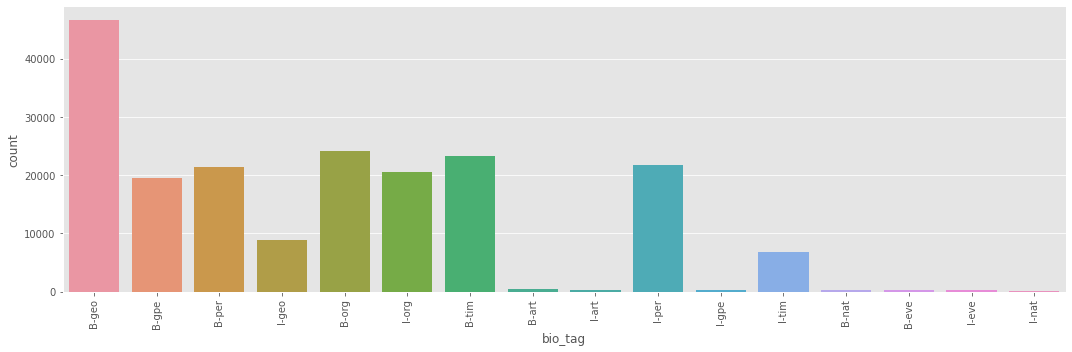

In [135]:
#Words distribution across Tags without O tag
import seaborn as sns
plt.figure(figsize=(15, 5))
ax = sns.countplot('bio_tag', data=voa_data.loc[voa_data['bio_tag'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

todo: add wordshape. from spacy for example

In [0]:
def get_sentences(df, word_col='word', pos_col='pos', 
                  tag_col='bio_tag', id_col='text_id'):
    """func to get the sentences in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_n, Tag_n)]"""
    
    agg_func = lambda s: [(w, p, t) for w, p, t in zip(s[word_col].values.tolist(),
                                                       s[pos_col].values.tolist(),
                                                       s[tag_col].values.tolist())]
    grouped = df.groupby(id_col).apply(agg_func)
    sentences = [s for s in grouped]
    
    return sentences

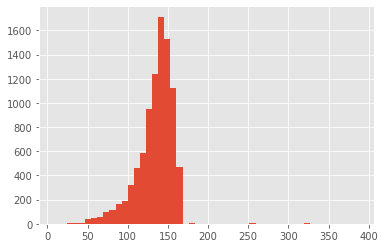

CPU times: user 2.05 s, sys: 222 ms, total: 2.27 s
Wall time: 2.28 s


In [137]:
%%time

word_pos_tag_sentences = get_sentences(voa_data)

#Lets visualize how the sentences are distributed by their length
plt.style.use("ggplot")
plt.hist([len(s) for s in word_pos_tag_sentences], bins=50)
plt.show()

create featuretfransformer like in https://www.depends-on-the-definition.com/introduction-named-entity-recognition-python/

Feature engineering – 2 (1+1) 
* add quotes before and after as features  
 
grammatical words = closed set (~ stop words)  
Stemming + POS  
Word shape  
Ad hoc features ( +1)

In [0]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        # 'word[-3:]': word[-3:], #replace with BPE
        # 'word[-2:]': word[-2:],
        # 'word.isupper()': word.isupper(),
        # 'word.istitle()': word.istitle(),
        # 'word.isdigit()': word.isdigit(),
        # 'postag': postag,
        # 'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        # features.update({
        #     '-1:word.lower()': word1.lower(),
        #     '-1:word.istitle()': word1.istitle(),
        #     '-1:word.isupper()': word1.isupper(),
        #     '-1:postag': postag1,
        #     '-1:postag[:2]': postag1[:2],
        # })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        # postag1 = sent[i+1][1]
        # features.update({
        #     '+1:word.lower()': word1.lower(),
        #     '+1:word.istitle()': word1.istitle(),
        #     '+1:word.isupper()': word1.isupper(),
        #     '+1:postag': postag1,
        #     '+1:postag[:2]': postag1[:2],
        # })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def get_sent_labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [139]:
%%time 

X = [sent2features(s) for s in word_pos_tag_sentences]
y = [get_sent_labels(s) for s in word_pos_tag_sentences]

#make a split while the data is still sequential
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False, random_state=42)

def get_flatten_and_lengths(X, y):
    lengths = [len(x) for x in X]
    flatten_X = [item for sublist in X for item in sublist]
    flatten_y = [item for sublist in y for item in sublist]
    assert len(flatten_X) == np.array(lengths).sum()
    return flatten_X, flatten_y, lengths
X_train_flatten, y_train_flatten, lengths_train = get_flatten_and_lengths(X_train, y_train)
X_test_flatten, y_test_flatten, lengths_test = get_flatten_and_lengths(X_test, y_test)

# check values for both: train and test
voa_train_test = pd.concat([pd.Series(y_train_flatten).value_counts().rename('bio_tag_train'), 
                            pd.Series(y_test_flatten).value_counts().rename('bio_tag_test')], 
                            axis=1)
print(voa_train_test.sort_values(by='bio_tag_train', ascending=False))

       bio_tag_train  bio_tag_test
O             829429        207114
B-geo          37235          9387
B-org          19134          4999
B-tim          18611          4691
I-per          17456          4343
B-per          17078          4291
I-org          16252          4274
B-gpe          15626          3843
I-geo           7114          1744
I-tim           5380          1415
B-art            383            72
I-art            281            54
B-eve            261            55
I-eve            220            41
B-nat            195            30
I-gpe            180            36
I-nat             47             8
CPU times: user 1.73 s, sys: 333 ms, total: 2.07 s
Wall time: 2.07 s


# Evaluation

In [0]:
def flatten(y):
    return list(chain.from_iterable(y))

def _flattens_y(func):
    @wraps(func)
    def wrapper(y_true, y_pred, *args, **kwargs):
        y_true_flat = flatten(y_true)
        y_pred_flat = flatten(y_pred)
        return func(y_true_flat, y_pred_flat, *args, **kwargs)
    return wrapper

In [141]:
def f1_macro(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

def fbeta_macro(y_true, y_pred, beta=2):
    return fbeta_score(y_true, y_pred, average='macro', beta=beta)

scoring = [bio_f_score, f1_macro, fbeta_macro]
cv = KFold(n_splits=5, shuffle=False, random_state=42)
sequence_cv = SequenceKFold(lengths_train, n_folds=5, n_iter=1, shuffle=False, random_state=42, yield_lengths=True)

def evaluate_bio_clf_report(y_test, y_pred, labels, remove_O=True,
                            do_flatten=False):
    if remove_O:
        labels.remove('O') # remove 'O' label from evaluation
    sorted_labels = sorted(labels,key=lambda name: (name[1:], name[0])) # group B and I results
    if do_flatten:
        report = flat_classification_report(y_test, y_pred, labels=sorted_labels, digits=3)
    else:
        report = classification_report(y_test, y_pred, labels=sorted_labels, digits=3)
    return report

def evaluate_entity_clf_report(y_test, y_pred, lengths_test):
    
    if len(y_pred) != len(y_test):
        logging.info("lengths of y_pred and y_test are not equal. trying to unflat predictions via lengths")
        assert sum(lengths_test) == len(y_pred)
        
        y_pred_copy = deepcopy(y_pred)
        y_pred_unflatten = []
        for length in lengths_test:
            y_pred_unflatten.append(y_pred_copy[:length].tolist())
            y_pred_copy = np.delete(y_pred_copy, range(length))
    else:
        y_pred_unflatten = y_pred
        
    return entity_classification_report(y_test, y_pred_unflatten)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


todo: add classification report on entities and bio_tag levels

# Training models

## HMM

###Supervised seqlearn
Given an observation sequence and the associated hidden states (real tags) we can learn the HMM parameters, that is, the matrices A and B.

In a HHM supervised scenario this is done by applying the Maximum Likelihood Estimation principle, which will compute the matrices.

This is achieved by counting how many times each event occurs in the corpus and normalizing the counts to form proper probability distributions.

In [0]:
pipe = Pipeline([('vectorizer', DictVectorizer(sparse=True)),
                 ('seq_clf', seqlearn_MHMM())])

In [0]:
def my_seq_cross_validate(estimator, X, y, cv, scoring):
    scores = dict((metric.__name__, []) for metric in scoring)
    for train, lengths_train, test, lengths_test in tqdm(list(cv), total=len(list(cv))):
        estimator_copy = deepcopy(estimator)
        model_name = estimator_copy.steps[-1][0]
        estimator_copy.fit(X[train], y[train], **{model_name+'__lengths': lengths_train})
        pred = estimator_copy.predict(X[test], **{'lengths': lengths_test})
        for metric in scoring:
            scores[metric.__name__].append(metric(y_true=y[test], y_pred=pred))
    
    scores_df = pd.DataFrame.from_dict(scores)
    scores_df.loc['mean'] = scores_df.mean()
    return scores_df

In [0]:
def grid_seq_cross_validate(parameter_dict, pipe, **kwargs):
    scores_dict = dict()
    grid_params_list = list(ParameterGrid(parameter_dict))
    for param_set in tqdm(grid_params_list, total=len(grid_params_list)):
        pipe_copy = deepcopy(pipe)
        # assuming that last step of pipeline is model
        pipe_copy[-1].__dict__.update(param_set)
        scores = my_seq_cross_validate(pipe_copy, **kwargs)
        scores_dict[str(pipe_copy[-1])] = scores
    return scores_dict

In [0]:
parameter_dict = {
    #Given a trained HMM i.e., the transition matrixes A and B, and a new observation sequence W=w1,w2,…,wN we want to find the sequence of states T=t1,t2,…,tN that best explains it.
    #This is can be achieved by using the Viterbi algorithm, that finds the best state assignment to the sequence T1…TN as a whole. 
    #There is another algorithm, Posterior Decoding (best-first) which consists in picking the highest state posterior for each position i in the sequence independently.
    'decode':['viterbi', 'bestfirst'], 
    'alpha':[0.001, 0.01, 0.1, 1.0]
}

In [0]:
%%time

scores_dict = grid_seq_cross_validate(parameter_dict, 
                                      pipe, 
                                      X=np.array(X_train_flatten),
                                      y=np.array(y_train_flatten),
                                      cv=sequence_cv,
                                      scoring=scoring)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until




CPU times: user 2min 26s, sys: 1.59 s, total: 2min 28s
Wall time: 2min 28s


In [0]:
scores_df = pd.concat(scores_dict.values(), keys=scores_dict.keys(), axis=1)
scores_df.T

0  ...      mean
MultinomialHMM(alpha=0.001, decode='viterbi')   bio_f_score  0.602240  ...  0.601818
                                                f1_macro     0.286838  ...  0.287269
                                                fbeta_macro  0.258712  ...  0.258485
MultinomialHMM(alpha=0.001, decode='bestfirst') bio_f_score  0.675595  ...  0.674505
                                                f1_macro     0.402382  ...  0.382823
                                                fbeta_macro  0.358670  ...  0.342333
MultinomialHMM(alpha=0.01, decode='viterbi')    bio_f_score  0.569115  ...  0.570155
                                                f1_macro     0.262675  ...  0.263328
                                                fbeta_macro  0.233159  ...  0.233046
MultinomialHMM(alpha=0.01, decode='bestfirst')  bio_f_score  0.675015  ...  0.674321
                                                f1_macro     0.379256  ...  0.362950
                                                fbeta_macro  0.340797  ...  0.327583
MultinomialHMM(alpha=0.1, decode='viterbi')     bio_f_score  0.458375  ...  0.459011
                                                f1_macro     0.202655  ...  0.201022
                                                fbeta_macro  0.173546  ...  0.172065
MultinomialHMM(alpha=0.1, decode='bestfirst')   bio_f_score  0.663210  ...  0.663272
                                                f1_macro     0.333049  ...  0.332700
                                                fbeta_macro  0.298961  ...  0.298410
MultinomialHMM(alpha=1.0, decode='viterbi')     bio_f_score  0.161203  ...  0.160512
                                                f1_macro     0.090295  ...  0.088777
                                                fbeta_macro  0.082487  ...  0.081439
MultinomialHMM(alpha=1.0, decode='bestfirst')   bio_f_score  0.599918  ...  0.601502
                                                f1_macro     0.280395  ...  0.279875
                                                fbeta_macro  0.244576  ...  0.244275

[24 rows x 6 columns]

Less alpha show better result. Ceteris paribus, bestfirst performs better

In [0]:
%%time
pipe = Pipeline([('vectorizer', DictVectorizer(sparse=True)),
                 ('seq_clf', seqlearn_MHMM(alpha=0.001, decode='bestfirst'))])
pipe.fit(X_train_flatten, y_train_flatten, **{'seq_clf__lengths': lengths_train})
y_pred_flatten = pipe.predict(X_test_flatten, **{'lengths': lengths_test})
print(y_pred_flatten[:15], '\n', y_test_flatten[:15])

['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'] 
 ['O', 'B-org', 'O', 'B-per', 'I-per', 'I-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O']
CPU times: user 4.14 s, sys: 25.8 ms, total: 4.16 s
Wall time: 4.17 s


In [0]:
np.unique(y_pred_flatten)

array(['O'], dtype='<U5')

In [0]:
np.unique(y_test_flatten)

array(['B-art', 'B-eve', 'B-geo', 'B-gpe', 'B-nat', 'B-org', 'B-per',
       'B-tim', 'I-art', 'I-eve', 'I-geo', 'I-gpe', 'I-nat', 'I-org',
       'I-per', 'I-tim', 'O'], dtype='<U5')

In [0]:
bio_f_score(y_test_flatten, y_pred_flatten)

0.0

In [0]:
bio_clf_report = evaluate_bio_clf_report(y_test_flatten, y_pred_flatten, 
                                         labels=list(estimator.classes_),
                                         do_flatten=False)
entity_clf_report = evaluate_entity_clf_report(y_test, y_pred_flatten, lengths_test)
print('*****BIO-tag LEVEL*****\n', bio_clf_report, '\n*****ENTITY LEVEL*****\n', entity_clf_report)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


*****BIO-tag LEVEL*****
               precision    recall  f1-score   support

       B-art      0.000     0.000     0.000        72
       I-art      0.000     0.000     0.000        54
       B-eve      0.800     0.218     0.343        55
       I-eve      0.000     0.000     0.000        41
       B-geo      0.763     0.793     0.778      9387
       I-geo      0.771     0.319     0.451      1744
       B-gpe      0.979     0.816     0.890      3843
       I-gpe      1.000     0.306     0.468        36
       B-nat      0.625     0.167     0.263        30
       I-nat      0.000     0.000     0.000         8
       B-org      0.788     0.257     0.388      4999
       I-org      0.468     0.020     0.039      4274
       B-per      0.694     0.514     0.591      4291
       I-per      0.873     0.544     0.670      4343
       B-tim      0.913     0.678     0.778      4691
       I-tim      0.991     0.081     0.150      1415

   micro avg      0.816     0.519     0.635     39283
 

###Handmade
The most trivial model = supervised HMM:
Take hmmlearn (former sklearn), modify MultinomialHMM (I.e. inherit a new class from _BaseHMM making it a modified copy of the latter) to allow for supervised HMM training. The states of the HMM model = the NE tags.  
NOTE: may use NaiveBayes to learn emission probabilities in a supervized manner.
Or implement from scratch (with Viterbi for prediction).  
NOTE: use tuples of features for X (not just the word, but additional info).  
NOTE: use smoothing for state transitions.


In [0]:
from hmmlearn.base import _BaseHMM
import scipy.sparse as sp
from scipy.special import logsumexp
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.utils import check_array
from sklearn.naive_bayes import MultinomialNB

In [0]:
def array2d(X, dtype=None, order=None, copy=False):
    """Returns at least 2-d array with data from X"""
    if sp.issparse(X):
        raise TypeError('A sparse matrix was passed, but dense data '
                        'is required. Use X.toarray() to convert to dense.')
    X_2d = np.asarray(np.atleast_2d(X), dtype=dtype, order=order)
    if X is X_2d and copy:
        X_2d = safe_copy(X_2d)
    return X_2d


def _atleast2d_or_sparse(X, dtype, order, copy, sparse_class, convmethod,
                         check_same_type):
    if sp.issparse(X):
        logging.info('X is sparse. Convert to csr if needed')
        if check_same_type(X) and X.dtype == dtype:
            X = getattr(X, convmethod)(copy=copy)
        elif dtype is None or X.dtype == dtype:
            X = getattr(X, convmethod)()
        else:
            X = sparse_class(X, dtype=dtype)
        X.data = np.array(X.data, copy=False, order=order)
    else:
        logging.info('Converting X to array2d')
        X = array2d(X, dtype=dtype, order=order, copy=copy)
    return X


def atleast2d_or_csr(X, dtype=None, order=None, copy=False):
    """Like numpy.atleast_2d, but converts sparse matrices to CSR format
    Also, converts np.matrix to np.ndarray.
    """
    return _atleast2d_or_sparse(X, dtype, order, copy, sp.csr_matrix,
                                "tocsr", sp.isspmatrix_csr)


def count_trans(y, n_classes):
    """Count transitions in a target vector.
    Parameters
    ----------
    y : array of integers, shape = n_samples
    n_classes : int
        Number of distinct labels.
    """
    trans = np.zeros((n_classes, n_classes), 
                     #dtype=np.intp
                     )

    for i in range(y.shape[0] - 1):
        trans[y[i], y[i + 1]] += 1
    return trans


def iter_from_X_lengths(X, lengths):
    if lengths is None:
        yield 0, len(X)
    else:
        n_samples = X.shape[0]
        end = np.cumsum(lengths).astype(np.int32)
        start = end - lengths
        if end[-1] > n_samples:
            raise ValueError("more than {:d} samples in lengths array {!s}"
                             .format(n_samples, lengths))

        for i in range(len(lengths)):
            yield start[i], end[i]


class my_hmm(hmmlearn_MHMM):
    def __init__(self, algorithm="viterbi", alpha=.01, 
                 use_MNB_for_emission=False, **kwargs):
        self.alpha = alpha
        self.algorithm = algorithm
        self.use_MNB_for_emission = use_MNB_for_emission
        hmmlearn_MHMM.__init__(self, **kwargs)

    def fit_supervised(self, X, y, lengths):
        """Fit HMM model to data by applying the Maximum Likelihood Estimation 
        principle, which will compute the matrices. This is achieved by counting 
        how many times each event occurs in the corpus and normalizing the 
        counts to form proper probability distributions.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            Feature matrix of individual samples.
        y : array-like, shape (n_samples,)
            Target labels.
        lengths : array-like of integers, shape (n_sequences,)
            Lengths of the individual sequences in X, y. The sum of these
            should be n_samples.
        """

        alpha = self.alpha
        if alpha < 0:
            raise ValueError("alpha should be >= 0, got {0!r}".format(alpha))

        X = atleast2d_or_csr(X)
        self.n_visible = X.shape[1]
        classes, y_indices = np.unique(y, return_inverse=True)
        self.n_hidden = len(classes)
        self.classes = classes
        lengths = np.asarray(lengths)
        # to list of one-hot vectors shape of (n_samples, unique_labels)
        Y = y_indices.reshape(-1, 1) == np.arange(len(classes))

        end_indices = np.cumsum(lengths)
        start_indices = end_indices - lengths
        end_indices -= 1

        # how much times each tag was at the beginning of the sequence
        log_init_prob = np.log(Y[start_indices].sum(axis=0) + alpha)
        # softmax, smoothing here is also taken into account 
        # (alpha taken the number of times equal number of classes)
        normalized_log_init_prob = log_init_prob - logsumexp(log_init_prob)
        init_prob = np.exp(normalized_log_init_prob)
        
        # how many times each tag was at the end of the sequence
        log_final_prob = np.log(Y[end_indices].sum(axis=0) + alpha)
        normalized_log_final_prob = log_final_prob - logsumexp(log_final_prob)
        final_prob = np.exp(normalized_log_final_prob)

        if self.use_MNB_for_emission:
            self.mnb = MultinomialNB(alpha=self.alpha, fit_prior=False)
            self.mnb.fit(X, y)             
            emission_prob = np.exp(self.mnb.feature_log_prob_) 
        else:
            # how many times each feature occured with each tag
            log_emission_prob = np.log(safe_sparse_dot(Y.T, X) + alpha)
            normalized_log_emission_prob = log_emission_prob - logsumexp(log_emission_prob, axis=1)[:, np.newaxis]
            emission_prob = np.exp(normalized_log_emission_prob)

        log_trans_prob = np.log(count_trans(y_indices, len(classes)) + alpha)
        normalized_log_trans_prob = log_trans_prob - logsumexp(log_trans_prob, axis=1)[:, np.newaxis]
        trans_prob = np.exp(normalized_log_trans_prob)

        self.startprob_ = init_prob
        self.transmat_ = trans_prob
        self.emissionprob_ = emission_prob 
        self.n_components = self.n_hidden  

    # def forward(self, input_seq):
    #     """Func to calculate forward probabilities, i.e. that the HMM will be in 
    #     a particular hidden state at a particular time step after emitting first
    #     t number of visible words from input_seq.
    #     Parameters
    #     ----------
    #     input_seq : {array-like, sparse matrix}, shape (n_samples, n_features)
    #         Feature matrix of individual samples.
    #     Returns
    #     -------
    #     forward_prob : np.array, shape(n_samples, n_hidden)
    #         Matrix of forward probabilities
    #     """
    #     input_seq_len = input_seq.shape[0]
    #     input_seq = atleast2d_or_csr(input_seq)

    #     forward_prob = np.zeros((input_seq_len, self.n_hidden))
    #     # element-wise multiplication
    #     forward_prob[0, :] = self.startprob_ * self.emissionprob_[:, input_seq[0]]
    
    #     for t in range(1, input_seq_len):
    #         for j in range(self.n_hidden):
    #             # probability that there will be a transition from any hidden 
    #             # state at (t−1) to a particular state j at time step t.
    #             state_j_prob = forward_prob[t - 1].dot(selt.transmat_[:, j])
    #             forward_prob[t, j] = state_j_prob * self.emissionprob_[j, input_seq[t]]
    #     return forward_prob
    
    # def backward(self, input_seq):
    #     """Func to calculate backward probabilities, i.e. that the HMM will be in 
    #     a particular hidden state at a particular time step and will generate 
    #     the remaining part visible words from input_seq.
    #     Parameters
    #     ----------
    #     input_seq : {array-like, sparse matrix}, shape (n_samples, n_features)
    #         Feature matrix of individual samples.
    #     Returns
    #     -------
    #     backward_prob : np.array, shape(n_samples, n_hidden)
    #         Matrix of backward probabilities
    #     """
    #     input_seq_len = input_seq.shape[0]
    #     input_seq = atleast2d_or_csr(input_seq)

    #     backward_prob = np.zeros((input_seq_len, self.n_hidden))
    #     # setting last column to 1
    #     backward_prob[input_seq_len - 1] = np.ones((self.n_hidden))
    
    #     # Loop in backward way from T-1 to
    #     # Due to python indexing the actual loop will be T-2 to 0
    #     for t in range(input_seq_len - 2, -1, -1):
    #         for j in range(self.n_hidden):
    #             backward_prob[t, j] = (backward_prob[t + 1] * self.emissionprob_[:, input_seq[t + 1]]).dot(self.transmat_[j, :])
    #     return backward_prob

    def _compute_log_likelihood(self, X):
        log_prob = safe_sparse_dot(X, np.log(self.emissionprob_.T))
        return log_prob

    # def viterbi(self, input_seq):
    #     """Func to calculate forward probabilities, i.e. that the HMM will be in 
    #     a particular hidden state at a particular time step after emitting first
    #     t number of visible words from input_seq.
    #     Parameters
    #     ----------
    #     input_seq : {array-like, sparse matrix}, shape (n_samples, n_features)
    #         Feature matrix of individual samples.
    #     Returns
    #     -------
    #     forward_prob : np.array, shape(n_samples, n_hidden)
    #         Matrix of forward probabilities
    #     """
    #     input_seq_len = input_seq.shape[0]
    #     input_seq = atleast2d_or_csr(input_seq)
    
    #     omega = np.zeros((input_seq_len, self.n_hidden))
    #     omega[0, :] = self.startprob_ * self.emissionprob_[:, input_seq[0]]
    
    #     prev = np.zeros((input_seq_len - 1, self.n_hidden))
    
    #     for t in range(1, input_seq_len):
    #         for j in range(self.n_hidden):
    #             # Same as Forward Probability
    #             state_j_prob = forward_prob[t - 1].dot(selt.transmat_[:, j])
    #             forward_prob[t, j] = state_j_prob * self.emissionprob_[j, input_seq[t]]
    
    #             # This is the most probable state given previous state at time t (1)
    #             prev[t - 1, j] = np.argmax(forward_prob)
    
    #             # This is the probability of the most probable state (2)
    #             omega[t, j] = np.max(forward_prob)
    
    #     # Path Array
    #     viterbi_path = np.zeros(input_seq_len)
    #     # Find the most probable last hidden state
    #     last_state = np.argmax(omega[input_seq_len - 1, :])
    #     viterbi_path[0] = last_state
    
    #     backtrack_index = 1
    #     for i in range(input_seq_len - 2, -1, -1):
    #         viterbi_path[backtrack_index] = prev[i, int(last_state)]
    #         last_state = prev[i, int(last_state)]
    #         backtrack_index += 1
    
    #     # Flip the path array since we were backtracking
    #     viterbi_path = np.flip(viterbi_path, axis=0)
    
    #     # Convert numeric values to actual hidden states
    #     result = []
    #     for s in viterbi_path:
    #         result.append(self.classes[s])    
    #     return result

    def _decode_viterbi(self, X):
        if sp.issparse(X):
            X = X.toarray()
        framelogprob = self._compute_log_likelihood(X)
        return self._do_viterbi_pass(framelogprob)

    def decode(self, X, lengths=None, algorithm=None):
        """Find most likely state sequence corresponding to ``X``.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Feature matrix of individual samples.
        lengths : array-like of integers, shape (n_sequences, ), optional
            Lengths of the individual sequences in ``X``. The sum of
            these should be ``n_samples``.
        algorithm : string
            Decoder algorithm. Must be one of "viterbi" or "map".
            If not given, :attr:`decoder` is used.
        Returns
        -------
        logprob : float
            Log probability of the produced state sequence.
        state_sequence : array, shape (n_samples, )
            Labels for each sample from ``X`` obtained via a given
            decoder ``algorithm``.
        See Also
        --------
        score_samples : Compute the log probability under the model and
            posteriors.
        score : Compute the log probability under the model.
        """
        algorithm = algorithm or self.algorithm
        decoder = {
            "viterbi": self._decode_viterbi,
            "map": self._decode_map
        }[algorithm]

        X = check_array(X, accept_sparse=True)
        n_samples = X.shape[0]
        logprob = 0
        state_sequence = np.empty(n_samples, dtype=int)
        for i, j in iter_from_X_lengths(X, lengths):
            # XXX decoder works on a single sample at a time!
            logprobij, state_sequenceij = decoder(X[i:j])
            logprob += logprobij
            state_sequence[i:j] = state_sequenceij

        return logprob, state_sequence

    def predict(self, X, lengths=None):
        """Find most likely state sequence corresponding to ``X``.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Feature matrix of individual samples.
        lengths : array-like of integers, shape (n_sequences, ), optional
            Lengths of the individual sequences in ``X``. The sum of
            these should be ``n_samples``.
        Returns
        -------
        state_sequence : array, shape (n_samples, )
            Labels for each sample from ``X``.
        """
        _, state_sequence = self.decode(X, lengths)
        return self.classes[state_sequence]

In [217]:
%%time 
dv = DictVectorizer(sparse=True, dtype=int)
X_train_flatten_vect = dv.fit_transform(X_train_flatten)
display(X_train_flatten_vect, X_train_flatten_vect.shape)

<984882x29197 sparse matrix of type '<class 'numpy.int64'>'
	with 1984430 stored elements in Compressed Sparse Row format>

(984882, 29197)

CPU times: user 2.1 s, sys: 4.72 ms, total: 2.1 s
Wall time: 2.1 s


In [218]:
inst = my_hmm(alpha=0.1, use_MNB_for_emission=True)
inst.fit_supervised(X_train_flatten_vect, y_train_flatten, lengths=lengths_train)
print(inst.startprob_.shape)
print(inst.transmat_.shape)
print(inst.emissionprob_.shape)

INFO      [2020-04-28 16:29:58,356] : X is sparse. Convert to csr if needed
(17,)
(17, 17)
(17, 29197)


In [219]:
inst.predict(X_train_flatten_vect[:np.cumsum(lengths_train[:2])[-1]].toarray(), lengths_train[:2])

array(['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O',
       'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'B-geo', 'I-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O',
       'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo',
       'B-tim', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'O', 'O',
       'B-geo', 'O', 'B-geo', 'O', 'O', 'B-geo', 'O', 'B-org', 'I-org',
       'I-org', 'I-org', 'I-org', 'O', 'O', 'O', 'O', 

In [86]:
inst.decode(X_train_flatten_vect, lengths=lengths_train, algorithm='viterbi')

Streaming output truncated to the last 5000 lines.
self.mnb.predict_log_proba(X) [-14.84737698 -12.08399398  -0.73926246  -3.93456432 -19.30593379
  -1.74710698  -9.70856142  -7.23247496 -16.32947456 -19.10971846
 -10.56965138 -19.4386597  -21.86895802 -11.74026975 -17.62643192
 -13.49515737  -1.11511429]
dot X and log(emission) [-19.86197504 -16.71507747 -10.33083    -12.65781887 -23.64549643
 -10.6728922  -18.52067087 -16.13054612 -21.03439231 -23.56990909
 -18.50603441 -23.69817964 -24.7856687  -20.50280409 -26.46043371
 -21.1521641  -13.81017016]
log norm prob [[-1.01431663e+01 -6.99626872e+00 -6.12021244e-01 ... -1.67416250e+01
  -1.14333553e+01 -4.09136141e+00]
 [-3.39894699e+00 -6.00361895e-01 -4.93774993e+00 ... -4.23554517e+00
  -3.37835097e+00 -4.51888647e+00]
 [-4.23557288e+00 -6.87940550e+00 -8.17227109e+00 ... -7.47006634e+00
  -6.61287213e+00 -5.60080167e-02]
 ...
 [-8.09763772e+00 -8.34357506e+00 -9.63644066e+00 ... -8.93423590e+00
  -1.28469727e+00 -3.60227322e-01]
 [-3

(-570414.3809766766, array([16, 16, 16, ..., 16, 16, 16]))

In [66]:
np.allclose(np.log(inst.emissionprob_).T, np.log(inst.emissionprob_.T), atol=1e-4)

True

In [67]:
inst.emissionprob_.max(axis=1)

array([0.10385773, 0.07581961, 0.47436451, 0.43780767, 0.05894794,
       0.45812952, 0.45722417, 0.46342727, 0.08073642, 0.0655118 ,
       0.41482358, 0.05491356, 0.01562863, 0.45877876, 0.46141463,
       0.3932333 , 0.49579228])

In [68]:
inst.emissionprob_.argmax(axis=1)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

###Unsupervised
use hmmlearn

In [0]:
np.array(X_train_flatten).reshape(-1, 1).shape

(984882, 1)

In [0]:
np.array(X_train_flatten).shape

(984882,)

In [0]:
unsupervised_hmm = hmmlearn_MHMM(n_components=unique_labels)
unsupervised_hmm.fit(np.array(X_train_flatten).reshape(-1, 1), lengths_train)

TypeError: ignored

## CRF

In [0]:
def run_rand_search(X_train, y_train, parameters):
    search = RandomizedSearchCV(estimator=CRF(),
                            param_distributions=parameters,
                            n_iter=10, scoring={metric.__name__:make_scorer(_flattens_y(metric)) for metric in scoring}, 
                            n_jobs=-1,
                            verbose=2,
                            cv=KFold(n_splits=3, shuffle=False, random_state=42),
                            refit='bio_f_score'#False,
                            )
    search.fit(X_train, y_train)
    return search

def show_reports(estimator):
    pred_unflatten = estimator.predict(X_test)
    bio_clf_report = evaluate_bio_clf_report(y_test, pred_unflatten, 
                                            labels=list(estimator.classes_),
                                            do_flatten=True)
    entity_clf_report = evaluate_entity_clf_report(y_test, pred_unflatten, lengths_test)
    print('*****BIO-tag LEVEL*****\n', bio_clf_report, '\n*****ENTITY LEVEL*****\n', entity_clf_report)

def show_search_results(search):
    full_df = pd.DataFrame(search.cv_results_)
    df_cutted = full_df.drop([k for k in search.cv_results_.keys() if any(col in k for col in ['split','std', 'params'])], axis=1)

    print('best params:', search.best_params_)
    print('best CV score:', search.best_score_)
    print('model size: {:0.2f}M'.format(search.best_estimator_.size_ / 1000000))

    show_reports(search.best_estimator_)

    return full_df, df_cutted, pred_unflatten

####Simple features (bias, lower, BOS, EOS) without tuning

In [146]:
%%time 

crf=CRF(algorithm='lbfgs',
         c1=0.1,
         c2=0.1,
         max_iterations=100,
         all_possible_transitions=False)

scores = cross_validate(crf, X_train, y_train, cv=cv, n_jobs=-1, 
                        scoring={metric.__name__:make_scorer(_flattens_y(metric)) for metric in scoring}, 
                        verbose=100, return_estimator=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Pickling array (shape=(5866,), dtype=int64).
Pickling array (shape=(1467,), dtype=int64).
Pickling array (shape=(5866,), dtype=int64).
Pickling array (shape=(1467,), dtype=int64).
Pickling array (shape=(5866,), dtype=int64).
Pickling array (shape=(1467,), dtype=int64).
Pickling array (shape=(5867,), dtype=int64).
Pickling array (shape=(1466,), dtype=int64).
Pickling array (shape=(5867,), dtype=int64).
Pickling array (shape=(1466,), dtype=int64).
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.2min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  4.5min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.0min finished
CPU times: user 1min 42s, sys: 1.37 s, total: 1min 44s
Wall time: 6min 1s


In [147]:
pd.DataFrame({k:v for k,v in scores.items() if 'test_' in k})

,test_bio_f_score,test_f1_macro,test_fbeta_macro
0,0.767883,0.556919,0.520987
1,0.789853,0.622899,0.578765
2,0.785177,0.584575,0.556278
3,0.780904,0.591135,0.566910
4,0.791902,0.602960,0.570546


In [148]:
show_reports(np.random.choice(scores['estimator']))

*****BIO-tag LEVEL*****
               precision    recall  f1-score   support

       B-art      0.500     0.056     0.100        72
       I-art      0.429     0.111     0.176        54
       B-eve      0.576     0.345     0.432        55
       I-eve      0.312     0.244     0.274        41
       B-geo      0.850     0.855     0.853      9387
       I-geo      0.785     0.741     0.763      1744
       B-gpe      0.972     0.940     0.956      3843
       I-gpe      0.955     0.583     0.724        36
       B-nat      0.889     0.267     0.410        30
       I-nat      0.714     0.625     0.667         8
       B-org      0.805     0.538     0.645      4999
       I-org      0.671     0.575     0.619      4274
       B-per      0.846     0.701     0.767      4291
       I-per      0.819     0.830     0.824      4343
       B-tim      0.927     0.768     0.840      4691
       I-tim      0.779     0.614     0.687      1415

   micro avg      0.838     0.744     0.788     39283
 

In [152]:
eli5.show_weights(np.random.choice(scores['estimator']), top=15)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


From \ To,O,B-art,I-art,B-eve,I-eve,B-geo,I-geo,B-gpe,I-gpe,B-nat,I-nat,B-org,I-org,B-per,I-per,B-tim,I-tim
O,4.209,3.332,0.0,3.299,0.0,4.9,0.0,3.718,0.0,3.636,0.0,4.581,0.0,5.059,0.0,3.312,0.0
B-art,0.962,0.0,10.694,0.0,0.0,0.467,0.0,0.0,0.0,0.0,0.0,0.61,0.0,0.966,0.0,1.057,0.0
I-art,0.021,0.0,9.521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.327,0.0,-1.143,0.0
B-eve,0.529,0.0,0.0,0.0,9.227,0.47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.376,0.0
I-eve,0.033,0.0,0.0,0.0,7.869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.238,0.0
B-geo,1.579,0.0,0.0,0.011,0.0,0.0,7.214,0.952,0.0,0.0,0.0,0.251,0.0,1.533,0.0,1.208,0.0
I-geo,0.901,0.133,0.0,0.0,0.0,0.0,6.388,0.0,0.0,0.0,0.0,0.193,0.0,1.119,0.0,0.142,0.0
B-gpe,2.163,-0.295,0.0,0.0,0.0,2.482,0.0,0.0,6.406,0.0,0.0,2.855,0.0,3.482,0.0,0.017,0.0
I-gpe,0.319,0.0,0.0,0.0,0.0,0.372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.817,0.0,0.0,0.0
B-nat,-0.309,0.0,0.0,0.0,0.0,0.603,0.0,0.0,0.0,0.0,7.197,0.0,0.0,0.764,0.0,-0.487,0.0


#### All features

##### GB methods

In [0]:
parameters = {'algorithm': ['lbfgs'], 
              'c1': [0.1, 0.01], 
              'c2': [0.1, 0.01],
              'all_possible_transitions': [True, False]}

search = run_rand_search(X_train, y_train, parameters)
full_df, df_cutted, pred_unflatten = show_search_results(search)
df_cutted

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 575.4min finished


best params: {'c2': 0.1, 'c1': 0.1, 'all_possible_transitions': True, 'algorithm': 'lbfgs'}
best CV score: 0.8442490525177447
model size: 3.13M
*****BIO-tag LEVEL*****
               precision    recall  f1-score   support

       B-art      0.452     0.194     0.272        72
       I-art      0.467     0.259     0.333        54
       B-eve      0.386     0.309     0.343        55
       I-eve      0.194     0.146     0.167        41
       B-geo      0.872     0.910     0.890      9387
       I-geo      0.813     0.818     0.815      1744
       B-gpe      0.974     0.956     0.965      3843
       I-gpe      0.812     0.722     0.765        36
       B-nat      0.846     0.367     0.512        30
       I-nat      0.833     0.625     0.714         8
       B-org      0.805     0.729     0.765      4999
       I-org      0.822     0.782     0.802      4274
       B-per      0.836     0.839     0.838      4291
       I-per      0.835     0.893     0.863      4343
       B-tim      0.

,mean_fit_time,mean_score_time,param_c2,param_c1,param_all_possible_transitions,param_algorithm,mean_test_bio_f_score,rank_test_bio_f_score,mean_test_f1_macro,rank_test_f1_macro,mean_test_fbeta_macro,rank_test_fbeta_macro
0,5078.268208,13.006236,0.1,0.1,True,lbfgs,0.844249,1,0.639689,3,0.623642,4
1,7884.569026,14.014825,0.01,0.1,True,lbfgs,0.839618,6,0.633747,6,0.620083,6
2,5042.338612,13.442750,0.1,0.01,True,lbfgs,0.843070,4,0.639646,4,0.624001,3
3,8294.303088,12.860991,0.01,0.01,True,lbfgs,0.833200,8,0.624828,7,0.614282,7
4,3874.859576,13.421319,0.1,0.1,False,lbfgs,0.844139,2,0.640371,2,0.624631,2
5,5902.170344,14.100148,0.01,0.1,False,lbfgs,0.839809,5,0.635455,5,0.623602,5
6,3715.930987,13.114199,0.1,0.01,False,lbfgs,0.843072,3,0.641796,1,0.627176,1
7,4059.283186,8.828271,0.01,0.01,False,lbfgs,0.833361,7,0.623698,8,0.613546,8


In [0]:
parameters = {'algorithm': ['l2sgd'], 
              'c2': [0.1, 0.01],
              'all_possible_transitions': [True, False]}

search = run_rand_search(X_train, y_train, parameters)
full_df, df_cutted, pred_unflatten = show_search_results(search)
df_cutted

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs

best params: {'c2': 0.1, 'all_possible_transitions': True, 'algorithm': 'l2sgd'}
best CV score: 0.8391407477825762
model size: 8.93M
*****BIO-tag LEVEL*****
               precision    recall  f1-score   support

       B-art      0.419     0.181     0.252        72
       I-art      0.370     0.185     0.247        54
       B-eve      0.386     0.309     0.343        55
       I-eve      0.222     0.244     0.233        41
       B-geo      0.848     0.929     0.886      9387
       I-geo      0.769     0.833     0.799      1744
       B-gpe      0.974     0.956     0.965      3843
       I-gpe      0.844     0.750     0.794        36
       B-nat      0.684     0.433     0.531        30
       I-nat      0.714     0.625     0.667         8
       B-org      0.829     0.701     0.760      4999
       I-org      0.857     0.743     0.796      4274
       B-per      0.819     0.839     0.829      4291
       I-per      0.814     0.908     0.858      4343
       B-tim      0.921     0.8

,mean_fit_time,mean_score_time,param_c2,param_all_possible_transitions,param_algorithm,mean_test_bio_f_score,rank_test_bio_f_score,mean_test_f1_macro,rank_test_f1_macro,mean_test_fbeta_macro,rank_test_fbeta_macro
0,537.090520,15.092035,0.1,True,l2sgd,0.839141,1,0.627980,4,0.616956,4
1,454.976540,14.281680,0.01,True,l2sgd,0.826727,4,0.635371,3,0.623382,3
2,639.355750,14.025988,0.1,False,l2sgd,0.839034,2,0.639518,2,0.624699,2
3,397.214507,8.920340,0.01,False,l2sgd,0.835731,3,0.645080,1,0.626771,1


##### Non-GB methods

In [0]:
parameters = {'algorithm': ['ap', 'pa', 'arow']}

search = run_rand_search(X_train, y_train, parameters)
full_df, df_cutted, pred_unflatten = show_search_results(search)
df_cutted

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs

best params: {'algorithm': 'pa'}
best CV score: 0.8419118105485338
model size: 5.10M
*****BIO-tag LEVEL*****
               precision    recall  f1-score   support

       B-art      0.381     0.222     0.281        72
       I-art      0.481     0.241     0.321        54
       B-eve      0.438     0.382     0.408        55
       I-eve      0.303     0.244     0.270        41
       B-geo      0.871     0.909     0.890      9387
       I-geo      0.813     0.814     0.814      1744
       B-gpe      0.970     0.957     0.964      3843
       I-gpe      0.844     0.750     0.794        36
       B-nat      0.812     0.433     0.565        30
       I-nat      1.000     0.625     0.769         8
       B-org      0.800     0.729     0.763      4999
       I-org      0.845     0.764     0.802      4274
       B-per      0.826     0.841     0.833      4291
       I-per      0.832     0.895     0.862      4343
       B-tim      0.921     0.879     0.900      4691
       I-tim      0.853  

,mean_fit_time,mean_score_time,param_algorithm,mean_test_bio_f_score,rank_test_bio_f_score,mean_test_f1_macro,rank_test_f1_macro,mean_test_fbeta_macro,rank_test_fbeta_macro
0,215.801909,12.645297,ap,0.840907,2,0.643963,2,0.627523,2
1,246.379716,11.997287,pa,0.841912,1,0.645208,1,0.628318,1
2,205.178590,8.887510,arow,0.755875,3,0.578727,3,0.572033,3


##NN:
Use keras or tensorflow;  
https://github.com/hse-aml/natural-language-processing/blob/master/week2/week2-NER.ipynb  
A plus for incorporating CNN-layers;

### Preprocessing

In [0]:
maxlen = 170

words = list(set(voa_data["word"].values))

words.append("ENDPAD")
#unique_labels = np.append(unique_labels, "ENDPAD")

word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(unique_labels)}

len(word2idx), len(tag2idx)

(35155, 17)

In [0]:
X = [[word2idx[w[0]] for w in s] for s in word_pos_tag_sentences]
X = pad_sequences(maxlen=maxlen, sequences=X, padding="post", value=len(words) - 1) # ENDPAD

y = [[tag2idx[w[2]] for w in s] for s in word_pos_tag_sentences]
y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["O"])
y = np.apply_along_axis(lambda x: to_categorical(x, num_classes=len(unique_labels)), axis=1, arr=y)

#make a split while the data is still sequential
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False, random_state=42)

In [0]:
def launch_nn(model, X_train, y_train, callbacks, **kwargs):
    display(model.summary())

    history = model.fit(X_train, y_train, batch_size=32, validation_split=0.2, 
                        verbose=1, callbacks=callbacks, epochs=50, **kwargs)
    
    return model


def estimate_nn(model, X_train, y_train, X_test, y_test, **kwargs):
    
    trained_model = launch_nn(model, X_train, y_train, **kwargs)

    pred = trained_model.predict(X_test)

    pred_tags = unique_labels[np.argmax(pred, axis=2)]
    test_tags = unique_labels[np.argmax(y_test, axis=2)]

    bio_clf_report = evaluate_bio_clf_report(test_tags, pred_tags, 
                                        labels=list(tag2idx.keys()),
                                        do_flatten=True)
    entity_clf_report = evaluate_entity_clf_report(test_tags.tolist(), pred_tags.tolist(), lengths_test)
    print('*****BIO-tag LEVEL*****\n', bio_clf_report, '\n*****ENTITY LEVEL*****\n', entity_clf_report)

    scores = dict((metric.__name__, []) for metric in scoring)
    for metric in scoring:
        scores[metric.__name__].append(metric(flatten(test_tags), flatten(pred_tags)))
    return scores

In [0]:
#   skf = StratifiedKFold(labels, n_folds=n_folds, shuffle=True)

#     for i, (train, test) in enumerate(skf):
#         print "Running Fold", i+1, "/", n_folds
#         model = None # Clearing the NN.
#         model = create_model()
#         train_and_evaluate_model(model, data[train], labels[train], data[test], labels[test])

### Bi-LSTM

In [0]:
def get_model():
    input = Input(shape=(maxlen,))
    masked_input = Masking(mask_value=len(words)-1)(input)
    model = Embedding(input_dim=len(words), output_dim=maxlen, input_length=maxlen)(masked_input)
    model = Dropout(0.1)(model)
    model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
    out = TimeDistributed(Dense(len(unique_labels), activation="softmax"))(model)  # softmax output layer
    model = Model(input, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [0]:
%%time 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, 
                   min_delta=0.001, restore_best_weights=True)
k.clear_session()
model = get_model()
scores = estimate_nn(model, X_train, y_train, X_test, y_test,
                     callbacks=[es])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5866 samples, validate on 1467 samples
Epoch 1/50
5866/5866 [==============================] - 89s 15ms/step - loss: 0.5682 - accuracy: 0.8831 - val_loss: 0.2593 - val_accuracy: 0.9293
Epoch 2/50
5866/5866 [==============================] - 86s 15ms/step - loss: 0.1671 - accuracy: 0.9561 - val_loss: 0.1191 - val_accuracy: 0.9666
Epoch 3/50
5866/5866 [==============================] - 86s 15ms/step - loss: 0.0930 - accuracy: 0.9735 - val_loss: 0.0980 - val_accuracy: 0.9712
Epoch 4/50
5866/5866 [==============================] - 86s 15ms/step - loss: 0.0732 - accuracy: 0.9783 - val_loss: 0.0930 - val_accuracy: 0.9723
Epoch 5/50
5866/5866 [==============================] - 86s 15ms/step - loss: 0.0632 - accuracy: 0.9808 - val_loss: 0.0914 - val_accuracy: 0.9730
Epoch 6/50
5866/5866 [==============================] - 86s 15ms/step - loss: 0.0556 - accuracy: 0.9827 - val_loss: 0.0913 - val_accuracy: 0.9734
Epoch 7/50
5866/5866 [==============================] - 86s 15ms/step - loss

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


*****BIO-tag LEVEL*****
               precision    recall  f1-score   support

       B-art      0.000     0.000     0.000        72
       I-art      0.000     0.000     0.000        54
       B-eve      0.000     0.000     0.000        55
       I-eve      0.000     0.000     0.000        41
       B-geo      0.866     0.885     0.875      9367
       I-geo      0.786     0.797     0.792      1741
       B-gpe      0.965     0.949     0.957      3842
       I-gpe      0.000     0.000     0.000        36
       B-nat      0.000     0.000     0.000        30
       I-nat      0.000     0.000     0.000         8
       B-org      0.785     0.682     0.730      4989
       I-org      0.824     0.713     0.765      4268
       B-per      0.857     0.774     0.814      4287
       I-per      0.852     0.821     0.836      4339
       B-tim      0.899     0.875     0.887      4687
       I-tim      0.797     0.652     0.717      1415

   micro avg      0.858     0.807     0.832     39231
 

In [0]:
scores

{'bio_f_score': [0.7995958613205606],
 'f1_macro': [0.4919339395406013],
 'fbeta_macro': [0.4839602387736253]}

### CRF-LSTM

In [0]:
def get_model():
    model = Sequential()
    model.add(Masking(mask_value=len(words)-1))
    model.add(Embedding(input_dim=len(words), output_dim=maxlen, input_length=maxlen))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.1)))
    model.add(TimeDistributed(Dense(len(unique_labels), activation="relu")))
    crf_layer = CRF_layer(len(unique_labels))
    model.add(crf_layer)
    model.compile(optimizer='adam', loss=crf_layer.loss_function, metrics=[crf_layer.accuracy])
    return model

In [0]:
%%time 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, 
                   min_delta=0.001, restore_best_weights=True)

k.clear_session()
model = get_model()
scores = estimate_nn(model, X_train, y_train, X_test, y_test,
                     callbacks=[es]])

/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5866 samples, validate on 1467 samples
Epoch 1/50
5866/5866 [==============================] - 87s 15ms/step - loss: 0.6081 - crf_viterbi_accuracy: 0.8574 - val_loss: 0.3027 - val_crf_viterbi_accuracy: 0.9112
Epoch 2/50
5866/5866 [==============================] - 86s 15ms/step - loss: 0.2146 - crf_viterbi_accuracy: 0.9340 - val_loss: 0.1479 - val_crf_viterbi_accuracy: 0.9595
Epoch 3/50
5866/5866 [==============================] - 85s 15ms/step - loss: 0.1155 - crf_viterbi_accuracy: 0.9667 - val_loss: 0.1071 - val_crf_viterbi_accuracy: 0.9684
Epoch 4/50
5866/5866 [==============================] - 86s 15ms/step - loss: 0.0867 - crf_viterbi_accuracy: 0.9742 - val_loss: 0.0948 - val_crf_viterbi_accuracy: 0.9711
Epoch 5/50
5866/5866 [==============================] - 86s 15ms/step - loss: 0.0733 - crf_viterbi_accuracy: 0.9775 - val_loss: 0.0898 - val_crf_viterbi_accuracy: 0.9722
Epoch 6/50
5866/5866 [==============================] - 86s 15ms/step - loss: 0.0647 - crf_viterbi_acc

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


*****BIO-tag LEVEL*****
               precision    recall  f1-score   support

       B-art      0.000     0.000     0.000        72
       I-art      0.000     0.000     0.000        54
       B-eve      0.000     0.000     0.000        55
       I-eve      0.000     0.000     0.000        41
       B-geo      0.870     0.878     0.874      9367
       I-geo      0.815     0.787     0.800      1741
       B-gpe      0.960     0.950     0.955      3842
       I-gpe      1.000     0.194     0.326        36
       B-nat      0.000     0.000     0.000        30
       I-nat      0.000     0.000     0.000         8
       B-org      0.760     0.700     0.729      4989
       I-org      0.821     0.724     0.770      4268
       B-per      0.834     0.784     0.808      4287
       I-per      0.844     0.842     0.843      4339
       B-tim      0.907     0.866     0.886      4687
       I-tim      0.823     0.666     0.736      1415

   micro avg      0.854     0.812     0.832     39231
 

In [0]:
scores

{'bio_f_score': [0.8190657130084935],
 'f1_macro': [0.5128074327403496],
 'fbeta_macro': [0.5000583143210557]}

###Bi-GRU-LSTM

In [0]:
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS

def get_model(with_hidden=False):

    input = Input(shape=(maxlen,))
    masked_input = Masking(mask_value=len(words)-1)(input)
    emb = Embedding(input_dim=len(words), output_dim=maxlen, input_length=maxlen)(masked_input)
    emb = SpatialDropout1D(0.2)(emb)
    gru = Bidirectional(GRU(LSTM_UNITS, return_sequences=True))(emb)
    #print('gru:', gru)
    lstm = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(gru)
    #print('lstm:', lstm)
    # print("GlobalMaxPooling1D ", GlobalMaxPooling1D()(lstm))
    # print("GlobalAveragePooling1D ", GlobalAveragePooling1D()(lstm))
    if with_hidden:
        hidden = Dense(DENSE_HIDDEN_UNITS, activation='relu')(lstm)
        #print('hidden:', hidden)
        hidden = Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)
        #print('hidden:', hidden)
        out = Dense(len(unique_labels), activation="softmax")(hidden)
    else:
        out = TimeDistributed(Dense(len(unique_labels), activation="softmax"))(lstm)

    model = Model(input, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [0]:
%%time 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, 
                   min_delta=0.001, restore_best_weights=True)

k.clear_session()
model = get_model()
scores = estimate_nn(model, X_train, y_train, X_test, y_test,
                     callbacks=[es])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 170)               0         
_________________________________________________________________
masking_1 (Masking)          (None, 170)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 170, 170)          5976350   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 170, 170)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 170, 256)          229632    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 170, 256)          394240    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 170, 17)           4369

None

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5866 samples, validate on 1467 samples
Epoch 1/50
5866/5866 [==============================] - 114s 19ms/step - loss: 0.4997 - accuracy: 0.8917 - val_loss: 0.2017 - val_accuracy: 0.9396
Epoch 2/50
5866/5866 [==============================] - 114s 19ms/step - loss: 0.1298 - accuracy: 0.9624 - val_loss: 0.1011 - val_accuracy: 0.9708
Epoch 3/50
5866/5866 [==============================] - 114s 19ms/step - loss: 0.0783 - accuracy: 0.9766 - val_loss: 0.0918 - val_accuracy: 0.9723
Epoch 4/50
5866/5866 [==============================] - 114s 19ms/step - loss: 0.0619 - accuracy: 0.9811 - val_loss: 0.0898 - val_accuracy: 0.9734
Epoch 5/50
5866/5866 [==============================] - 113s 19ms/step - loss: 0.0530 - accuracy: 0.9835 - val_loss: 0.0888 - val_accuracy: 0.9738
Epoch 6/50
5866/5866 [==============================] - 113s 19ms/step - loss: 0.0465 - accuracy: 0.9853 - val_loss: 0.0919 - val_accuracy: 0.9733
Epoch 7/50
5866/5866 [==============================] - 111s 19ms/step

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


*****BIO-tag LEVEL*****
               precision    recall  f1-score   support

       B-art      0.000     0.000     0.000        72
       I-art      0.067     0.019     0.029        54
       B-eve      0.000     0.000     0.000        55
       I-eve      0.000     0.000     0.000        41
       B-geo      0.868     0.884     0.876      9367
       I-geo      0.794     0.775     0.785      1741
       B-gpe      0.956     0.949     0.953      3842
       I-gpe      1.000     0.167     0.286        36
       B-nat      0.000     0.000     0.000        30
       I-nat      0.000     0.000     0.000         8
       B-org      0.766     0.702     0.732      4989
       I-org      0.848     0.687     0.759      4268
       B-per      0.852     0.760     0.804      4287
       I-per      0.837     0.849     0.843      4339
       B-tim      0.906     0.871     0.888      4687
       I-tim      0.824     0.628     0.712      1415

   micro avg      0.857     0.806     0.831     39231
 

In [0]:
scores

{'bio_f_score': [0.8022472329544393],
 'f1_macro': [0.5092808837444268],
 'fbeta_macro': [0.4949153658402649]}

In [0]:
%%time 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, 
                   min_delta=0.001, restore_best_weights=True)

k.clear_session()
model = get_model(with_hidden=True)
scores = estimate_nn(model, X_train, y_train, X_test, y_test,
                     callbacks=[es])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 170)               0         
_________________________________________________________________
masking_1 (Masking)          (None, 170)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 170, 170)          5976350   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 170, 170)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 170, 256)          229632    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 170, 256)          394240    
_________________________________________________________________
dense_1 (Dense)              (None, 170, 512)          1315

None

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5866 samples, validate on 1467 samples
Epoch 1/50
5866/5866 [==============================] - 113s 19ms/step - loss: 0.4697 - accuracy: 0.8953 - val_loss: 0.1881 - val_accuracy: 0.9431
Epoch 2/50
5866/5866 [==============================] - 112s 19ms/step - loss: 0.1240 - accuracy: 0.9638 - val_loss: 0.1042 - val_accuracy: 0.9696
Epoch 3/50
5866/5866 [==============================] - 114s 20ms/step - loss: 0.0768 - accuracy: 0.9766 - val_loss: 0.0952 - val_accuracy: 0.9721
Epoch 4/50
5866/5866 [==============================] - 110s 19ms/step - loss: 0.0600 - accuracy: 0.9814 - val_loss: 0.0944 - val_accuracy: 0.9725
Epoch 5/50
5866/5866 [==============================] - 111s 19ms/step - loss: 0.0503 - accuracy: 0.9841 - val_loss: 0.1036 - val_accuracy: 0.9716
Epoch 6/50
5866/5866 [==============================] - 111s 19ms/step - loss: 0.0427 - accuracy: 0.9864 - val_loss: 0.1024 - val_accuracy: 0.9721
Restoring model weights from the end of the best epoch
Epoch 00006: ea

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


*****BIO-tag LEVEL*****
               precision    recall  f1-score   support

       B-art      0.000     0.000     0.000        72
       I-art      0.000     0.000     0.000        54
       B-eve      0.000     0.000     0.000        55
       I-eve      0.000     0.000     0.000        41
       B-geo      0.861     0.875     0.868      9367
       I-geo      0.802     0.761     0.781      1741
       B-gpe      0.963     0.942     0.952      3842
       I-gpe      0.913     0.583     0.712        36
       B-nat      0.000     0.000     0.000        30
       I-nat      0.000     0.000     0.000         8
       B-org      0.765     0.679     0.720      4989
       I-org      0.828     0.689     0.752      4268
       B-per      0.826     0.766     0.795      4287
       I-per      0.803     0.889     0.844      4339
       B-tim      0.925     0.834     0.877      4687
       I-tim      0.840     0.564     0.675      1415

   micro avg      0.850     0.799     0.823     39231
 

In [0]:
scores

{'bio_f_score': [0.7942519019442096],
 'f1_macro': [0.527458967735135],
 'fbeta_macro': [0.5129062405476958]}

### Flair embeddings

In [0]:
! pip install tiny-tokenizer
! pip install flair

import flair
from flair.data import Sentence
import torch

! pip install allennlp
from flair.embeddings import StackedEmbeddings, RoBERTaEmbeddings, ELMoEmbeddings

In [0]:
elmo_embeddings = ELMoEmbeddings('original')
roberta_embeddings = RoBERTaEmbeddings('roberta-base')
stacked_embeddings = StackedEmbeddings([
                                        elmo_embeddings,
                                        roberta_embeddings,
                                       ])

# create a sentence #
sentence = Sentence('test sent')
# embed words in sentence #
stacked_embeddings.embed(sentence)
embedding_len = sentence[0].embedding.size()[0]
print('embedding len', embedding_len)

In [0]:
embedding_matrix = np.zeros((len(word2idx) + 1, embedding_len)) # zeroth row for UNK
print('embedding matrix shape', embedding_matrix.shape)

embedding matrix shape (35156, 3840)


In [0]:
for word, i in tqdm(word2idx.items(), total=len(word2idx)):
    try:
        word_sent = Sentence(word)
        stacked_embeddings.embed(word_sent)
        embedding_vector = word_sent[0].embedding.cpu().detach().numpy()
        if (embedding_vector is not None) and len(embedding_vector) > 0:
           embedding_matrix[i] = embedding_vector
    except KeyError:
        pass

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [0]:
import gc
del stacked_embeddings
gc.collect()

0

In [0]:
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS

def get_model(with_hidden=False):

    input = Input(shape=(maxlen,))
    masked_input = Masking(mask_value=len(words)-1)(input)
    #emb = Embedding(input_dim=len(words), output_dim=embedding_len, input_length=maxlen)(masked_input)
    emb = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(masked_input)
    emb = SpatialDropout1D(0.2)(emb)
    gru = Bidirectional(GRU(LSTM_UNITS, return_sequences=True))(emb)
    #print('gru:', gru)
    lstm = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(gru)
    #print('lstm:', lstm)
    out = TimeDistributed(Dense(len(unique_labels), activation="softmax"))(lstm)

    model = Model(input, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [0]:
%%time 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, 
                   min_delta=0.001, restore_best_weights=True)

k.clear_session()
model = get_model()
scores = estimate_nn(model, X_train, y_train, X_test, y_test,
                     callbacks=[es])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 170)               0         
_________________________________________________________________
masking_1 (Masking)          (None, 170)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 170, 3840)         134999040 
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 170, 3840)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 170, 256)          3048192   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 170, 256)          394240    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 170, 17)           4369

None

Train on 5866 samples, validate on 1467 samples
Epoch 1/50
5866/5866 [==============================] - 194s 33ms/step - loss: 0.1867 - accuracy: 0.9511 - val_loss: 0.0842 - val_accuracy: 0.9746
Epoch 2/50
5866/5866 [==============================] - 192s 33ms/step - loss: 0.0797 - accuracy: 0.9756 - val_loss: 0.0733 - val_accuracy: 0.9770
Epoch 3/50
5866/5866 [==============================] - 197s 34ms/step - loss: 0.0690 - accuracy: 0.9777 - val_loss: 0.0684 - val_accuracy: 0.9782
Epoch 4/50
5866/5866 [==============================] - 200s 34ms/step - loss: 0.0621 - accuracy: 0.9796 - val_loss: 0.0678 - val_accuracy: 0.9780
Epoch 5/50
5866/5866 [==============================] - 199s 34ms/step - loss: 0.0570 - accuracy: 0.9808 - val_loss: 0.0660 - val_accuracy: 0.9787
Epoch 6/50
5866/5866 [==============================] - 197s 34ms/step - loss: 0.0525 - accuracy: 0.9822 - val_loss: 0.0673 - val_accuracy: 0.9783
Epoch 7/50
5866/5866 [==============================] - 195s 33ms/step

In [0]:
scores

{'bio_f_score': [0.8336841327868247],
 'f1_macro': [0.6504073046551951],
 'fbeta_macro': [0.6159101860901762]}